# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

In [25]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D, LSTM, TimeDistributed, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from keras.models import Sequential
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam



We set the random seed so that the results don't vary drastically.

In [26]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras

import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [27]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
batch_size = 32
print("Training data size:", len(train_doc))
print("Validation data size:", len(val_doc))
print("Batch Size:", batch_size)

Training data size: 663
Validation data size: 100
Batch Size: 32


## Utils

In [28]:
def plot_model_performace(model_history, num_epochs):
    plt.figure(figsize = (10,10))

    plt.figure(figsize = (10,10))

    acc = model_history.history['categorical_accuracy']
    val_acc = model_history.history['val_categorical_accuracy']

    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']

    epochs_range = range(num_epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [29]:
from imageio import imread
from skimage.transform import resize
import numpy as np
import os

def generator(source_path, folder_list, batch_size, img_index, height, width):
    print('Source path =', source_path, '; batch size =', batch_size)
    img_idx = img_index
    
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t) // batch_size
        
        for batch in range(num_batches):  # Iterate over the number of batches
            batch_data = np.zeros((batch_size, len(img_idx), height, width, 3))  # (batch_size, num_images, height, width, channels)
            batch_labels = np.zeros((batch_size, 5))  # One-hot encoding for labels
            
            for folder in range(batch_size):  # Iterate over the batch_size
                folder_path = os.path.join(source_path, t[folder + (batch * batch_size)].split(';')[0])
                imgs = os.listdir(folder_path)  # List all images in the folder
                
                for idx, item in enumerate(img_idx):  # Iterate over selected frame indices
                    image_path = os.path.join(folder_path, imgs[item])
                    image = imread(image_path).astype(np.float32)
                    
                    image = resize(image, (height, width)).astype(np.float32)

                    # Normalize and add to batch
                    batch_data[folder, idx, :, :, 0] = image[:, :, 0] / 255  # Normalize Red channel
                    batch_data[folder, idx, :, :, 1] = image[:, :, 1] / 255  # Normalize Green channel
                    batch_data[folder, idx, :, :, 2] = image[:, :, 2] / 255  # Normalize Blue channel
                
                # Assign label to the batch (one-hot encoding)
                label_idx = int(t[folder + (batch * batch_size)].split(';')[2])
                batch_labels[folder, label_idx] = 1

            yield batch_data, batch_labels  # Yield the batch data and labels

        # Handle the remaining batch (if the data size isn't perfectly divisible by batch_size)
        if len(t) % batch_size != 0:
            remaining_batch_size = len(t) % batch_size
            batch_data = np.zeros((remaining_batch_size, len(img_idx), height, width, 3))  # Adjust for the remaining size
            batch_labels = np.zeros((remaining_batch_size, 5))
            
            for folder in range(remaining_batch_size):  # Iterate over the remaining batch size
                folder_path = os.path.join(source_path, t[folder + (num_batches * batch_size)].split(';')[0])
                imgs = os.listdir(folder_path)
                
                for idx, item in enumerate(img_idx):
                    image_path = os.path.join(folder_path, imgs[item])
                    image = imread(image_path).astype(np.float32)
                    
                    # Resize the image
                    image = resize(image, (height, width)).astype(np.float32)

                    # Normalize and add to batch
                    batch_data[folder, idx, :, :, 0] = image[:, :, 0] / 255
                    batch_data[folder, idx, :, :, 1] = image[:, :, 1] / 255
                    batch_data[folder, idx, :, :, 2] = image[:, :, 2] / 255

                # Assign label to the batch (one-hot encoding)
                label_idx = int(t[folder + (num_batches * batch_size)].split(';')[2])
                batch_labels[folder, label_idx] = 1

            yield batch_data, batch_labels  # Yield the remaining batch


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [30]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


Source path = /home/datasets/Project_data/train ; batch size = 32


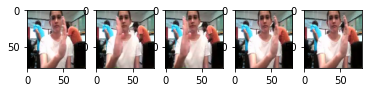

In [31]:
# testing generator
img_index = [1,2,3, 4,5, 6,7, 8,9, 10,11, 12,13, 14,15, 16,17, 18,19, 20,21, 22,23, 24,25, 26,27,28,29]
height = width = 80
train_generator = generator(train_path, train_doc, batch_size, img_index, height, width)
batch_data, batch_labels=next(train_generator)
fig, axes = plt.subplots(nrows=1, ncols=5)
axes[0].imshow(batch_data[0,1,:,:,:])   
axes[1].imshow(batch_data[0,3,:,:,:])
axes[2].imshow(batch_data[0,5,:,:,:]) 
axes[3].imshow(batch_data[0,7,:,:,:]) 
axes[4].imshow(batch_data[0,9,:,:,:]) 

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## Model 1: 3D convolution model
This model is designed for processing sequences of images (13 frames of size 80x80x3). The model includes the following main components:

- 3D Convolutions: To capture spatio-temporal features from the video frames.
- Max Pooling: To reduce the dimensionality and keep the important features.
- Fully Connected Layers: To combine and interpret the features extracted by the convolutions.
- Dropout: To regularize the model and avoid overfitting.
- Softmax Output Layer: To predict the class probabilities for each input video sequence.

Batch size is 32

In [32]:

#write your model here
model = Sequential()
model.add(Conv3D(32, (3, 3, 3), padding='same',
         input_shape=(13,80,80,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5,activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [33]:
optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 13, 80, 80, 32)    2624      
                                                                 
 activation (Activation)     (None, 13, 80, 80, 32)    0         
                                                                 
 batch_normalization_6 (Batc  (None, 13, 80, 80, 32)   128       
 hNormalization)                                                 
                                                                 
 max_pooling3d (MaxPooling3D  (None, 6, 40, 40, 32)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 6, 40, 40, 64)     16448     
                                                                 
 activation_1 (Activation)   (None, 6, 40, 40, 64)    

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [34]:
img_index = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26]
height = width = 80
train_generator = generator(train_path, train_doc, batch_size, img_index, height, width)
val_generator = generator(val_path, val_doc, batch_size, img_index, height, width)

In [35]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(
    filepath, 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=False, 
    save_weights_only=False, 
    mode='auto', 
    save_freq='epoch'  # Save at the end of each epoch
)

LR = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    verbose=1, 
    patience=4  # Adjust the patience depending on your dataset and model
)

callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.

In [36]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [37]:
history = model.fit(
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=num_epochs, 
    verbose=1, 
    callbacks=callbacks_list, 
    validation_data=val_generator, 
    validation_steps=validation_steps, 
    class_weight=None, 
    workers=1, 
    initial_epoch=0
)

Source path = /home/datasets/Project_data/train ; batch size = 32
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.8974 - categorical_accuracy: 0.3348Source path = /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_2025-01-2911_01_40.920122/model-00001-1.89740-0.33484-1.68241-0.18000.h5
21/21 [==============================] - 36s 2s/step - loss: 1.8974 - categorical_accuracy: 0.3348 - val_loss: 1.6824 - val_categorical_accuracy: 0.1800 - lr: 0.0100
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.3401 - categorical_accuracy: 0.5053
Epoch 00002: saving model to model_init_2025-01-2911_01_40.920122/model-00002-1.34014-0.50528-1.77058-0.34000.h5
21/21 [==============================] - 34s 2s/step - loss: 1.3401 - categorical_accuracy: 0.5053 - val_loss: 1.7706 - val_categorical_accuracy: 0.3400 - lr: 0.0100
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 1.1124 - categorical_accuracy: 0

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

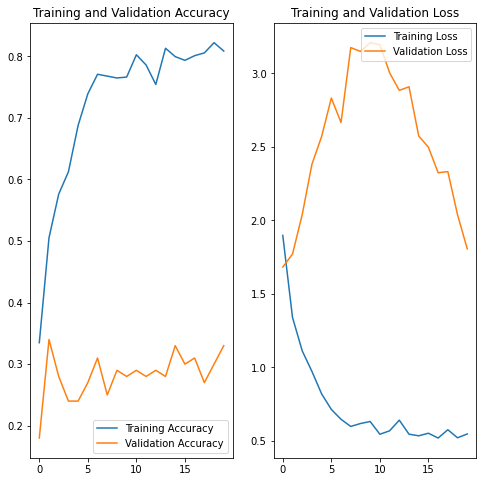

In [38]:
plot_model_performace(history, num_epochs)

Insights:
- Training Progress: The model's training accuracy steadily improves, while the validation accuracy stagnates, indicating potential overfitting or poor generalization.

- Learning Rate Adjustment: The learning rate decreases multiple times during training due to the ReduceLROnPlateau callback, helping refine the model but also signaling potential plateauing.

- Validation Loss: The validation loss fluctuates, with no significant improvement despite reducing the learning rate, which suggests that the model is struggling to generalize well to unseen data.

Next steps:
Let us try adding more data. Try with more frames per sequence.



## Model 2: More frames per second

In [39]:
# Define parameters
batch_size = 32  # Batch size for training
height = width = 80  # Image dimensions (height, width)
img_index = [0,1,3,5,6,7,9,10,11,13,15,16,17,19,20,21,23,25,26,27,29]  # Selected image indices

# Build the model
model = Sequential()

# 3D Convolutional Layer 1
model.add(Conv3D(32, (3, 3, 3), padding='same', input_shape=(len(img_index), height, width, 3)))  # Input shape: (depth, height, width, channels)
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# 3D Convolutional Layer 2
model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# 3D Convolutional Layer 3
model.add(Conv3D(128, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Fully connected layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# Output layer
model.add(Dense(5, activation='softmax'))  # 5 output classes


In [40]:
# Set up training and validation generators
train_generator = generator(train_path, train_doc, batch_size, img_index, height, width)
val_generator = generator(val_path, val_doc, batch_size, img_index, height, width)

# Create model name with timestamp
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'

# Check if the directory for saving the model exists, if not, create it
if not os.path.exists(model_name):
    os.mkdir(model_name)

# Define file path for model checkpoints
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# Define model checkpoint callback to save model after each epoch
checkpoint = ModelCheckpoint(filepath, 
                              monitor='val_loss', 
                              verbose=1, 
                              save_best_only=False, 
                              save_weights_only=False, 
                              mode='auto', 
                              period=1)

# Define learning rate scheduler to reduce LR on plateaus in validation loss
LR = ReduceLROnPlateau(monitor='val_loss', 
                       factor=0.2, 
                       verbose=1, 
                       patience=4)

# List of callbacks for training
callbacks_list = [checkpoint, LR]

# Compile the model with Adam optimizer, categorical crossentropy loss, and categorical accuracy metric
optimiser = 'Adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary
print(model.summary())


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 21, 80, 80, 32)    2624      
                                                                 
 activation_3 (Activation)   (None, 21, 80, 80, 32)    0         
                                                                 
 batch_normalization_11 (Bat  (None, 21, 80, 80, 32)   128       
 chNormalization)                                                
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 10, 40, 40, 32)   0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 10, 40, 40, 64)    16448     
                                                                 
 activation_4 (Activation)   (None, 10, 40, 40, 64)   

In [41]:
steps_per_epoch=0
validation_steps=0
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [42]:
history2 = model.fit(
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=num_epochs, 
    verbose=1, 
    callbacks=callbacks_list, 
    validation_data=val_generator, 
    validation_steps=validation_steps, 
    class_weight=None, 
    workers=1, 
    initial_epoch=0
)

Source path = /home/datasets/Project_data/train ; batch size = 32
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.6045 - categorical_accuracy: 0.3967Source path = /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_2025-01-2911_01_40.920122/model-00001-1.60451-0.39668-1.84840-0.21000.h5
21/21 [==============================] - 59s 3s/step - loss: 1.6045 - categorical_accuracy: 0.3967 - val_loss: 1.8484 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.0277 - categorical_accuracy: 0.6259
Epoch 00002: saving model to model_init_2025-01-2911_01_40.920122/model-00002-1.02765-0.62594-2.59812-0.27000.h5
21/21 [==============================] - 55s 3s/step - loss: 1.0277 - categorical_accuracy: 0.6259 - val_loss: 2.5981 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 0.7938 - categorical_accuracy: 0

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

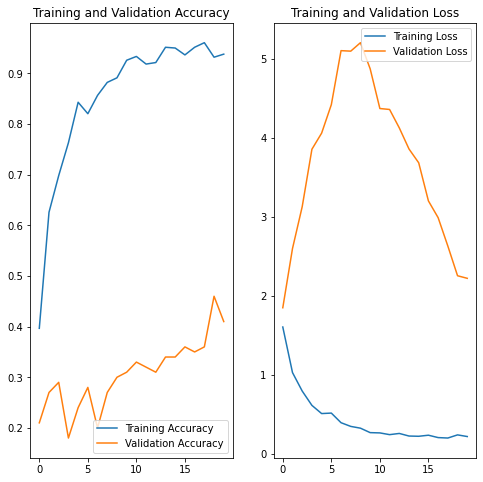

In [43]:
plot_model_performace(history2, num_epochs)

The gap between training accuracy and validation accuracy is wide throughout the training. By epoch 20, the training accuracy reaches ~0.96, but the validation accuracy is still at 0.36.

This large gap indicates overfitting: The model is performing very well on the training data but not generalizing effectively to unseen data (validation set).

# Model 3: Image size 120*120

In [16]:
# Parameters
batch_size = 32  # Batch size
height = width = 120  # Image dimensions
img_index = [0,1,3,5,6,7,9,10,11,13,15,16,17,19,20,21,23,25,26,27,29]  # Image indices

# Build the model
model = Sequential()

# 1st Convolutional Block
model.add(Conv3D(32, (3, 3, 3), padding='same', input_shape=(len(img_index), height, width, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# 2nd Convolutional Block
model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# 3rd Convolutional Block
model.add(Conv3D(128, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Fully connected layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# Output layer
model.add(Dense(5, activation='softmax'))  # 5 classes


In [17]:
# Set up training and validation data generators
train_generator = generator(train_path, train_doc, batch_size, img_index, height, width)
val_generator = generator(val_path, val_doc, batch_size, img_index, height, width)

# Create model directory with timestamp
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'
if not os.path.exists(model_name):
    os.mkdir(model_name)

# Define file path for model checkpoint saving
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# Set up checkpoint callback
checkpoint = ModelCheckpoint(filepath, 
                              monitor='val_loss', 
                              verbose=1, 
                              save_best_only=False, 
                              save_weights_only=False, 
                              mode='auto', 
                              period=1)

# Learning rate reduction on plateau
LR = ReduceLROnPlateau(monitor='val_loss', 
                       factor=0.2, 
                       verbose=1, 
                       patience=4)  # Reduce learning rate when validation loss plateaus

# List of callbacks for training
callbacks_list = [checkpoint, LR]

# Compile the model with Adam optimizer and categorical crossentropy loss
optimiser = 'Adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print model summary
print(model.summary())


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 21, 120, 120, 32)  2624      
                                                                 
 activation_6 (Activation)   (None, 21, 120, 120, 32)  0         
                                                                 
 batch_normalization_10 (Bat  (None, 21, 120, 120, 32)  128      
 chNormalization)                                                
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 10, 60, 60, 32)   0         
 3D)                                                             
                                                                 
 conv3d_7 (Conv3D)           (None, 10, 60, 60, 64)    16448     
                                                                 
 activation_7 (Activation)   (None, 10, 60, 60, 64)   

In [18]:
steps_per_epoch=0
validation_steps=0
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [40]:
history3 = model.fit(
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=num_epochs, 
    verbose=1, 
    callbacks=callbacks_list, 
    validation_data=val_generator, 
    validation_steps=validation_steps, 
    class_weight=None, 
    workers=1, 
    initial_epoch=0
)

Source path = /home/datasets/Project_data/train ; batch size = 32
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.4446 - categorical_accuracy: 0.4676Source path = /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_2025-01-2816_37_12.476033/model-00001-1.44455-0.46757-2.14658-0.21000.h5
21/21 [==============================] - 80s 4s/step - loss: 1.4446 - categorical_accuracy: 0.4676 - val_loss: 2.1466 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 0.9244 - categorical_accuracy: 0.6169
Epoch 00002: saving model to model_init_2025-01-2816_37_12.476033/model-00002-0.92445-0.61689-2.88867-0.21000.h5
21/21 [==============================] - 76s 4s/step - loss: 0.9244 - categorical_accuracy: 0.6169 - val_loss: 2.8887 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 0.6779 - categorical_accuracy: 0

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

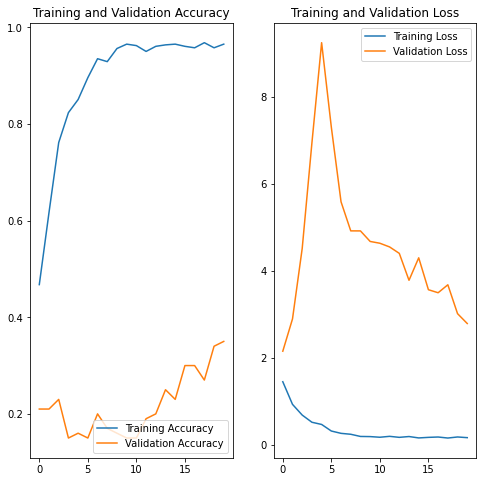

In [ ]:
plot_model_performace(history3, num_epochs)

Increasing the image size did not help and neither did adding more frames. Next let us try adding regularization and increasing drop out

## Model 4: Parameter tuning

* Kernel size: (3,3,3): Using a larger kernel size may capture more spatial information in each convolution, which could help in learning more complex patterns in the data.

* Added L2 regularization 

* Dropout: Increased dropout to 0.5 for first two layers and 0.3 for last layer

In [19]:
# Build the model
model = Sequential()

# First Convolution Block
model.add(Conv3D(32, (3, 3, 3), padding='same', input_shape=(len(img_index), height, width, 3)))  # Input shape: (depth, height, width, channels)
model.add(Activation('relu'))  # ReLU activation
model.add(BatchNormalization())  # Batch normalization to stabilize training
model.add(MaxPooling3D(pool_size=(2, 2, 2)))  # Max pooling to reduce dimensionality

# Second Convolution Block
model.add(Conv3D(64, (3, 3, 3), padding='same'))  # 64 filters, 3D convolution
model.add(Activation('relu'))  # ReLU activation
model.add(BatchNormalization())  # Batch normalization
model.add(MaxPooling3D(pool_size=(2, 2, 2)))  # Max pooling

# Third Convolution Block
model.add(Conv3D(128, (3, 3, 3), padding='same'))  # 128 filters, 3D convolution
model.add(Activation('relu'))  # ReLU activation
model.add(BatchNormalization())  # Batch normalization
model.add(MaxPooling3D(pool_size=(2, 2, 2)))  # Max pooling

# Flatten and Dense Layers
model.add(Flatten())  # Flatten the 3D output to 1D
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))  # Dense layer with L2 regularization
model.add(BatchNormalization())  # Batch normalization
model.add(Dropout(0.5))  # Dropout for regularization

model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))  # Dense layer with L2 regularization
model.add(BatchNormalization())  # Batch normalization
model.add(Dropout(0.5))  # Dropout

model.add(Dense(64, activation='relu'))  # Dense layer
model.add(BatchNormalization())  # Batch normalization
model.add(Dropout(0.3))  # Dropout

# Output Layer
model.add(Dense(5, activation='softmax'))  # Softmax output for 5 classes

# Set up data generators for training and validation
train_generator = generator(train_path, train_doc, batch_size, img_index, height, width)
val_generator = generator(val_path, val_doc, batch_size, img_index, height, width)

# Define model saving directory with timestamp
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'
if not os.path.exists(model_name):
    os.mkdir(model_name)

# Define file path for saving model checkpoints
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# ModelCheckpoint callback to save the model after each epoch
checkpoint = ModelCheckpoint(filepath, 
                              monitor='val_loss', 
                              verbose=1, 
                              save_best_only=False, 
                              save_weights_only=False, 
                              mode='auto', 
                              period=1)

# Learning rate reduction on plateau callback
LR = ReduceLROnPlateau(monitor='val_loss', 
                       factor=0.5,  # Reduce LR by 50%
                       verbose=1, 
                       patience=3,  # Wait for 3 epochs before reducing LR
                       min_lr=1e-6)  # Minimum LR limit

# List of callbacks for training
callbacks_list = [checkpoint, LR]

# Compile the model with Adam optimizer and categorical crossentropy loss
optimiser = 'Adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary
print(model.summary())


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_9 (Conv3D)           (None, 21, 120, 120, 32)  2624      
                                                                 
 activation_9 (Activation)   (None, 21, 120, 120, 32)  0         
                                                                 
 batch_normalization_15 (Bat  (None, 21, 120, 120, 32)  128      
 chNormalization)                                                
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 10, 60, 60, 32)   0         
 3D)                                                             
                                                                 
 conv3d_10 (Conv3D)          (None, 10, 60, 60, 64)    55360     
                                                                 
 activation_10 (Activation)  (None, 10, 60, 60, 64)   

In [20]:
steps_per_epoch=0
validation_steps=0
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [46]:
history4 = model.fit(
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=num_epochs, 
    verbose=1, 
    callbacks=callbacks_list, 
    validation_data=val_generator, 
    validation_steps=validation_steps, 
    class_weight=None, 
    workers=1, 
    initial_epoch=0
)

Source path = /home/datasets/Project_data/train ; batch size = 32
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 2.7401 - categorical_accuracy: 0.3092Source path = /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_2025-01-2816_37_12.476033/model-00001-2.74006-0.30920-3.13513-0.31000.h5
21/21 [==============================] - 86s 4s/step - loss: 2.7401 - categorical_accuracy: 0.3092 - val_loss: 3.1351 - val_categorical_accuracy: 0.3100 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 2.7055 - categorical_accuracy: 0.4118
Epoch 00002: saving model to model_init_2025-01-2816_37_12.476033/model-00002-2.70551-0.41176-6.26358-0.25000.h5
21/21 [==============================] - 73s 4s/step - loss: 2.7055 - categorical_accuracy: 0.4118 - val_loss: 6.2636 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 2.6638 - categorical_accuracy: 0

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

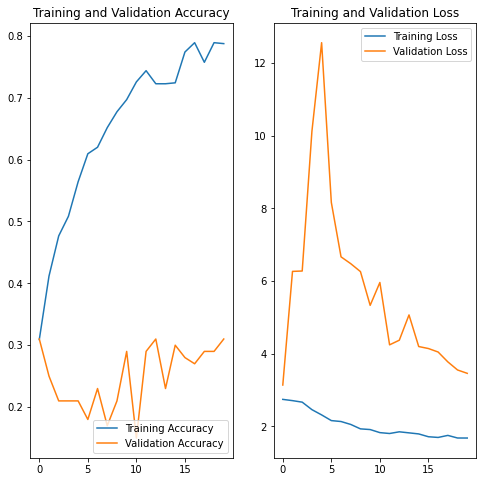

In [ ]:
plot_model_performace(history4, num_epochs)

Even with regularization and increased dropouts we are not seeing much imrpovement in overfitting. Next we try to use a larger batch size 

## Model 5: Increase number of frames to 30 and reduce size to 84

In [21]:
# Set parameters
batch_size = 32  # Batch size for training
height = width = 84  # Image dimensions (height, width)
img_index = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]  # Selected image indices

# Build the model
model = Sequential()

# First Convolution Block
model.add(Conv3D(32, (3, 3, 3), padding='same', input_shape=(len(img_index), height, width, 3)))  # Input shape: (depth, height, width, channels)
model.add(Activation('relu'))  # ReLU activation
model.add(BatchNormalization())  # Normalize activations
model.add(MaxPooling3D(pool_size=(2, 2, 2)))  # Max pooling to reduce dimensionality

# Second Convolution Block
model.add(Conv3D(64, (3, 3, 3), padding='same'))  # 64 filters, 3D convolution
model.add(Activation('relu'))  # ReLU activation
model.add(BatchNormalization())  # Normalize activations
model.add(MaxPooling3D(pool_size=(2, 2, 2)))  # Max pooling

# Third Convolution Block
model.add(Conv3D(128, (3, 3, 3), padding='same'))  # 128 filters, 3D convolution
model.add(Activation('relu'))  # ReLU activation
model.add(BatchNormalization())  # Normalize activations
model.add(MaxPooling3D(pool_size=(2, 2, 2)))  # Max pooling

# Flatten and Dense Layers
model.add(Flatten())  # Flatten the 3D output to 1D
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))  # Dense layer with L2 regularization
model.add(BatchNormalization())  # Normalize activations
model.add(Dropout(0.5))  # Dropout for regularization

model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))  # Dense layer with L2 regularization
model.add(BatchNormalization())  # Normalize activations
model.add(Dropout(0.5))  # Dropout

model.add(Dense(64, activation='relu'))  # Dense layer
model.add(BatchNormalization())  # Normalize activations
model.add(Dropout(0.3))  # Dropout

# Output Layer
model.add(Dense(5, activation='softmax'))  # Softmax output for 5 classes

# Set up training and validation data generators
train_generator = generator(train_path, train_doc, batch_size, img_index, height, width)
val_generator = generator(val_path, val_doc, batch_size, img_index, height, width)

# Define model saving directory with timestamp
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'
if not os.path.exists(model_name):
    os.mkdir(model_name)

# Define file path for saving model checkpoints
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# ModelCheckpoint callback to save the model after each epoch
checkpoint = ModelCheckpoint(filepath, 
                              monitor='val_loss', 
                              verbose=1, 
                              save_best_only=False, 
                              save_weights_only=False, 
                              mode='auto', 
                              period=1)

# Learning rate reduction on plateau callback
LR = ReduceLROnPlateau(monitor='val_loss', 
                       factor=0.5,  # Reduce LR by 50%
                       verbose=1, 
                       patience=3,  # Wait for 3 epochs before reducing LR
                       min_lr=1e-6)  # Minimum LR limit

# List of callbacks for training
callbacks_list = [checkpoint, LR]

# Compile the model with Adam optimizer and categorical crossentropy loss
optimiser = 'Adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary
print(model.summary())


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 30, 84, 84, 32)    2624      
                                                                 
 activation_12 (Activation)  (None, 30, 84, 84, 32)    0         
                                                                 
 batch_normalization_21 (Bat  (None, 30, 84, 84, 32)   128       
 chNormalization)                                                
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 15, 42, 42, 32)   0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 15, 42, 42, 64)    55360     
                                                                 
 activation_13 (Activation)  (None, 15, 42, 42, 64)   

In [22]:
steps_per_epoch=0
validation_steps=0
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [31]:
history5 = model.fit(
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=num_epochs, 
    verbose=1, 
    callbacks=callbacks_list, 
    validation_data=val_generator, 
    validation_steps=validation_steps, 
    class_weight=None, 
    workers=1, 
    initial_epoch=0
)

Source path = /home/datasets/Project_data/train ; batch size = 32
Epoch 1/20


2025-01-29 02:00:48.961635: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


21/21 [==============================] - ETA: 0s - loss: 2.8477 - categorical_accuracy: 0.2775Source path = /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_2025-01-2901_48_01.439734/model-00001-2.84772-0.27753-2.95471-0.30000.h5
21/21 [==============================] - 179s 9s/step - loss: 2.8477 - categorical_accuracy: 0.2775 - val_loss: 2.9547 - val_categorical_accuracy: 0.3000 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 2.7091 - categorical_accuracy: 0.3635
Epoch 00002: saving model to model_init_2025-01-2901_48_01.439734/model-00002-2.70906-0.36350-2.69471-0.35000.h5
21/21 [==============================] - 158s 8s/step - loss: 2.7091 - categorical_accuracy: 0.3635 - val_loss: 2.6947 - val_categorical_accuracy: 0.3500 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 2.5342 - categorical_accuracy: 0.4419
Epoch 00003: saving model to model_init_2025-01-2901_48_01.439734/mod

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

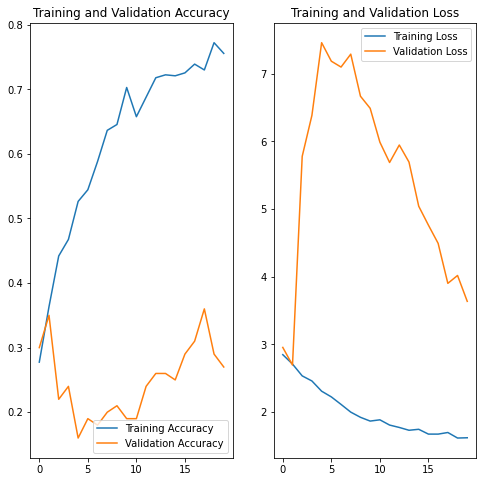

In [32]:
plot_model_performace(history5, num_epochs)

No significant improvement in overfitting with increase in number of frames

## Model 6: Increase batch size and number of epochs

Batch Size: 64

Epochs: 30

In [23]:
batch_size = 64
height=width = 84
img_index = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29]

model = Sequential()

# First Convolution Block
model.add(Conv3D(32, (3, 3, 3), padding='same', input_shape=(len(img_index), height, width, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Second Convolution Block
model.add(Conv3D(64, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Third Convolution Block
model.add(Conv3D(128, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Flatten and Dense Layers
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Output Layer
model.add(Dense(5, activation='softmax'))


# Generate training and validation data
train_generator = generator(train_path, train_doc, batch_size, img_index, height, width)
val_generator = generator(val_path, val_doc, batch_size, img_index, height, width)

# Define model name with timestamp
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'

# Create directory to save the model if it doesn't exist
if not os.path.exists(model_name):
    os.mkdir(model_name)

# Define file path for saving model checkpoints
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# Define ModelCheckpoint callback to save the model after each epoch
checkpoint = ModelCheckpoint(filepath, 
                              monitor='val_loss', 
                              verbose=1, 
                              save_best_only=False, 
                              save_weights_only=False, 
                              mode='auto', 
                              period=1)

# Define ReduceLROnPlateau callback to reduce learning rate if validation loss plateaus
LR = ReduceLROnPlateau(monitor='val_loss', 
                       factor=0.5,         # Reduce LR by 50%
                       verbose=1, 
                       patience=3,         # Wait for 3 epochs before reducing LR
                       min_lr=1e-6)        # Minimum LR limit

# List of callbacks to use during training
callbacks_list = [checkpoint, LR]

# Compile the model with SGD optimizer and categorical crossentropy loss function
optimiser = 'sgd'  # Stochastic Gradient Descent optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary to check the architecture
print(model.summary())


steps_per_epoch=0
validation_steps=0
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_15 (Conv3D)          (None, 30, 84, 84, 32)    2624      
                                                                 
 activation_15 (Activation)  (None, 30, 84, 84, 32)    0         
                                                                 
 batch_normalization_27 (Bat  (None, 30, 84, 84, 32)   128       
 chNormalization)                                                
                                                                 
 max_pooling3d_15 (MaxPoolin  (None, 15, 42, 42, 32)   0         
 g3D)                                                            
                                                                 
 conv3d_16 (Conv3D)          (None, 15, 42, 42, 64)    55360     
                                                                 
 activation_16 (Activation)  (None, 15, 42, 42, 64)   

In [35]:
num_epochs =30
history6 = model.fit(
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=num_epochs, 
    verbose=1, 
    callbacks=callbacks_list, 
    validation_data=val_generator, 
    validation_steps=validation_steps, 
    class_weight=None, 
    workers=1, 
    initial_epoch=0
)

Source path = /home/datasets/Project_data/train ; batch size = 64
Epoch 1/30
11/11 [==============================] - ETA: 0s - loss: 2.7360 - categorical_accuracy: 0.2941 Source path = /home/datasets/Project_data/val ; batch size = 64

Epoch 00001: saving model to model_init_2025-01-2901_48_01.439734/model-00001-2.73596-0.29412-2.31096-0.22000.h5
11/11 [==============================] - 162s 16s/step - loss: 2.7360 - categorical_accuracy: 0.2941 - val_loss: 2.3110 - val_categorical_accuracy: 0.2200 - lr: 0.0100
Epoch 2/30
11/11 [==============================] - ETA: 0s - loss: 2.4708 - categorical_accuracy: 0.3560 
Epoch 00002: saving model to model_init_2025-01-2901_48_01.439734/model-00002-2.47082-0.35596-2.33104-0.33000.h5
11/11 [==============================] - 154s 15s/step - loss: 2.4708 - categorical_accuracy: 0.3560 - val_loss: 2.3310 - val_categorical_accuracy: 0.3300 - lr: 0.0100
Epoch 3/30
11/11 [==============================] - ETA: 0s - loss: 2.3071 - categorical_accur

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

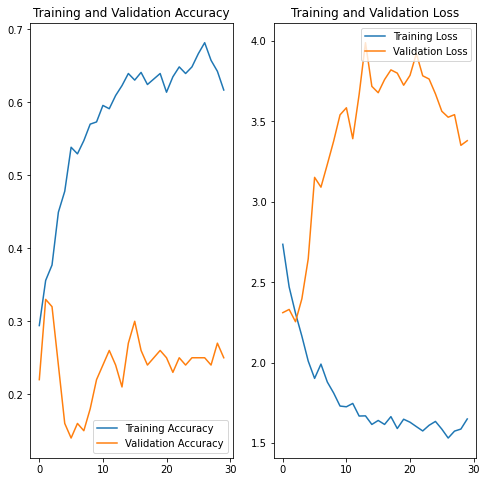

In [36]:
plot_model_performace(history6, num_epochs)

With larger batch size its observed that training time reduces.

Even with higher number of epochs we dont see a significant improvement in the model.

In the above experiments we observed that with 3D convolution network we are not able to get a good model.

## Model 7: CNN + LSTM model

This model combines spatial feature extraction (with Conv3D) and temporal sequence modeling (with LSTM) to handle videos or sequences of images. 

In [24]:
# Parameters
batch_size = 32
height = width = 84
img_index = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]

# Build the model
model = Sequential()

# 1st Convolutional Block
model.add(Conv3D(32, (3, 3, 3), padding='same', input_shape=(len(img_index), height, width, 3)))  # Input shape: (depth, height, width, channels)
model.add(Activation('relu'))  # ReLU activation
model.add(BatchNormalization())  # Batch normalization to stabilize training
model.add(MaxPooling3D(pool_size=(2, 2, 2)))  # Max pooling to reduce dimensionality

# 2nd Convolutional Block
model.add(Conv3D(64, (2, 2, 2), padding='same'))  # 64 filters, 3D convolution
model.add(Activation('relu'))  # ReLU activation
model.add(BatchNormalization())  # Batch normalization
model.add(MaxPooling3D(pool_size=(2, 2, 2)))  # Max pooling

# 3rd Convolutional Block
model.add(Conv3D(128, (2, 2, 2), padding='same'))  # 128 filters, 3D convolution
model.add(Activation('relu'))  # ReLU activation
model.add(BatchNormalization())  # Batch normalization
model.add(MaxPooling3D(pool_size=(2, 2, 2)))  # Max pooling

# TimeDistributed Flatten and LSTM Layer
model.add(TimeDistributed(Flatten()))  # Flatten the 3D outputs for sequence processing
model.add(LSTM(128))  # LSTM layer to capture temporal dependencies
model.add(Dropout(0.5))  # Dropout for regularization

# Dense Layer
model.add(Dense(64, activation='relu'))  # Fully connected layer with ReLU
model.add(BatchNormalization())  # Batch normalization
model.add(Dropout(0.25))  # Dropout for regularization

# Output Layer
model.add(Dense(5, activation='softmax'))  # Softmax for 5-class classification


In [25]:
# Generate training and validation data
train_generator = generator(train_path, train_doc, batch_size, img_index, height, width)
val_generator = generator(val_path, val_doc, batch_size, img_index, height, width)

# Define model name with timestamp
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'

# Create the model directory if it doesn't exist
if not os.path.exists(model_name):
    os.mkdir(model_name)

# Define file path for saving model checkpoints
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# ModelCheckpoint callback to save the model after each epoch
checkpoint = ModelCheckpoint(filepath, 
                              monitor='val_loss', 
                              verbose=1, 
                              save_best_only=False, 
                              save_weights_only=False, 
                              mode='auto', 
                              period=1)

# Learning rate reduction on plateau callback
LR = ReduceLROnPlateau(monitor='val_loss', 
                       factor=0.5,         # Reduce LR by 50%
                       verbose=1, 
                       patience=3,         # Wait for 3 epochs before reducing LR
                       min_lr=1e-6)        # Minimum LR limit

# List of callbacks to use during training
callbacks_list = [checkpoint, LR]

# Compile the model with Adam optimizer and categorical crossentropy loss function
optimiser = 'Adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary to check the architecture
print(model.summary())


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_18 (Conv3D)          (None, 30, 84, 84, 32)    2624      
                                                                 
 activation_18 (Activation)  (None, 30, 84, 84, 32)    0         
                                                                 
 batch_normalization_33 (Bat  (None, 30, 84, 84, 32)   128       
 chNormalization)                                                
                                                                 
 max_pooling3d_18 (MaxPoolin  (None, 15, 42, 42, 32)   0         
 g3D)                                                            
                                                                 
 conv3d_19 (Conv3D)          (None, 15, 42, 42, 64)    16448     
                                                                 
 activation_19 (Activation)  (None, 15, 42, 42, 64)   

In [26]:
steps_per_epoch=0
validation_steps=0
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [44]:
# Set the number of epochs
num_epochs = 20

# Train the model using the fit_generator method
history7 = model.fit_generator(
    train_generator,                  
    steps_per_epoch=steps_per_epoch,   
    epochs=num_epochs,                 
    verbose=1,                          
    callbacks=callbacks_list,          
    validation_data=val_generator,     
    validation_steps=validation_steps, 
    class_weight=None,                 
    workers=1,                         
    initial_epoch=0                    
)


/tmp/ipykernel_233/135919201.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history7 = model.fit_generator(


Source path = /home/datasets/Project_data/train ; batch size = 32
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 2.1440 - categorical_accuracy: 0.2413Source path = /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_2025-01-2901_48_01.439734/model-00001-2.14396-0.24133-1.55547-0.30000.h5
21/21 [==============================] - 160s 8s/step - loss: 2.1440 - categorical_accuracy: 0.2413 - val_loss: 1.5555 - val_categorical_accuracy: 0.3000 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.8961 - categorical_accuracy: 0.2670
Epoch 00002: saving model to model_init_2025-01-2901_48_01.439734/model-00002-1.89608-0.26697-1.55701-0.28000.h5
21/21 [==============================] - 160s 8s/step - loss: 1.8961 - categorical_accuracy: 0.2670 - val_loss: 1.5570 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 1.7413 - categorical_accuracy:

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

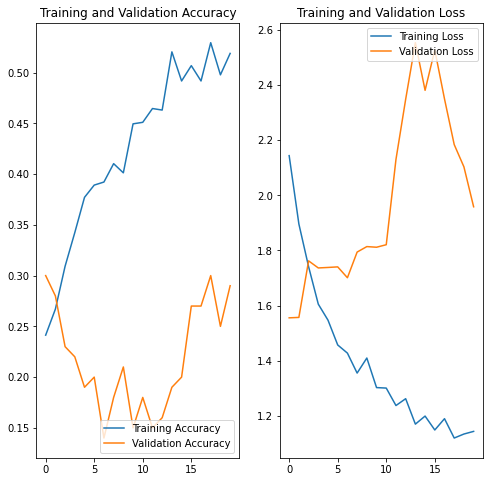

In [45]:
plot_model_performace(history7, num_epochs)

- The highest validation accuracy is 0.30 (achieved in epoch 18), which is relatively low, and it hasn't shown significant improvement as the epochs progress.
- For comparison, the training accuracy has been somewhat increasing, but it's still below 0.55 by the final epoch. A performance gap between training and validation accuracy indicates the model might not have learned the underlying patterns of the data well enough.
- This could be a sign of underfitting
- Also the model is not generalizing well as validation loss remains high

## Model 8: CNN + GRU

The model is designed for handling 3D sequential data like video frames, where each frame is processed independently by the convolutional layers, followed by temporal processing with a GRU (Gated Recurrent Unit) to capture the temporal dependencies between frames. 

In [27]:
batch_size = 32
height = width = 120
img_index = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]

# Assuming RGB images (3 channels)
input_shape = (len(img_index), height, width, 3)  # (time_steps, height, width, channels)

GRU_lstm = Sequential()

# Conv2D layer wrapped with TimeDistributed
GRU_lstm.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'), input_shape=input_shape))
GRU_lstm.add(TimeDistributed(BatchNormalization()))
GRU_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

GRU_lstm.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
GRU_lstm.add(TimeDistributed(BatchNormalization()))
GRU_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

GRU_lstm.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
GRU_lstm.add(TimeDistributed(BatchNormalization()))
GRU_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

GRU_lstm.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu')))
GRU_lstm.add(TimeDistributed(BatchNormalization()))
GRU_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

# Flattening the output of the last Conv2D layer
GRU_lstm.add(TimeDistributed(Flatten()))

# GRU Layer
GRU_lstm.add(GRU(128))
GRU_lstm.add(Dropout(0.25))

# Dense Layer
GRU_lstm.add(Dense(128, activation='relu'))
GRU_lstm.add(Dropout(0.25))

# Output Layer (5 classes)
GRU_lstm.add(Dense(5, activation='softmax'))


In [28]:
# Set up data generators for training and validation
train_generator = generator(train_path, train_doc, batch_size, img_index, height, width)
val_generator = generator(val_path, val_doc, batch_size, img_index, height, width)

# Define model name with timestamp
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'

# Create the model directory if it doesn't exist
if not os.path.exists(model_name):
    os.mkdir(model_name)

# Define file path for saving model checkpoints
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# ModelCheckpoint callback to save the model after each epoch
checkpoint = ModelCheckpoint(filepath, 
                              monitor='val_loss', 
                              verbose=1, 
                              save_best_only=False, 
                              save_weights_only=False, 
                              mode='auto', 
                              period=1)

# Learning rate reduction on plateau callback
LR = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,          # Reduce LR by 50%
    verbose=1, 
    patience=3,          # Wait for 3 epochs before reducing LR
    min_lr=1e-6          # Minimum LR limit
)

# List of callbacks to use during training
callbacks_list = [checkpoint, LR]

# Compile the model with Adam optimizer and categorical crossentropy loss function
optimiser = 'Adam'
GRU_lstm.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary to check the architecture
print(GRU_lstm.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_1 (TimeDis  (None, 30, 120, 120, 16)  448      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 30, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 30, 60, 60, 32)  

In [29]:
steps_per_epoch=0
validation_steps=0
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [30]:
num_epochs = 20
history8 = GRU_lstm.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                        callbacks=callbacks_list, validation_data=val_generator, 
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path = /home/datasets/Project_data/train ; batch size = 32
Epoch 1/20


2025-01-29 06:01:15.360012: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


21/21 [==============================] - ETA: 0s - loss: 1.4780 - categorical_accuracy: 0.3891Source path = /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_2025-01-2905_59_14.525011/model-00001-1.47799-0.38914-1.55140-0.20000.h5
21/21 [==============================] - 164s 8s/step - loss: 1.4780 - categorical_accuracy: 0.3891 - val_loss: 1.5514 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.1634 - categorical_accuracy: 0.5249
Epoch 00002: saving model to model_init_2025-01-2905_59_14.525011/model-00002-1.16339-0.52489-2.15783-0.15000.h5
21/21 [==============================] - 156s 8s/step - loss: 1.1634 - categorical_accuracy: 0.5249 - val_loss: 2.1578 - val_categorical_accuracy: 0.1500 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 0.9417 - categorical_accuracy: 0.6440
Epoch 00003: saving model to model_init_2025-01-2905_59_14.525011/mod

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

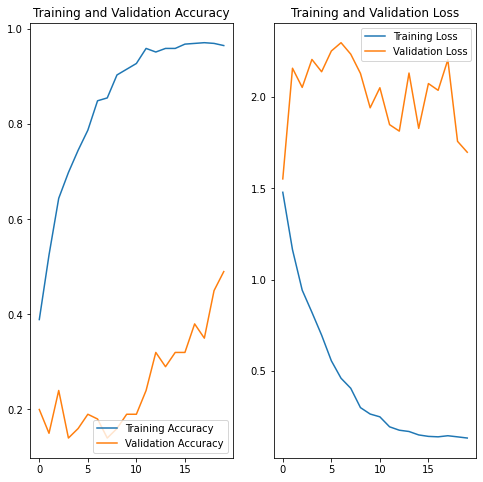

In [31]:
plot_model_performace(history8, num_epochs)

Looks like the Model is underfitting:

- Training accuracy steadily improves and reaches 96.53% by epoch 20.
Validation accuracy, however, lags behind significantly, reaching only 49.00% at epoch 20.
- If the model were overfitting, you would expect the validation accuracy to increase as training accuracy improves, but instead, it remains quite low.

- Training loss consistently decreases (good sign of learning), but validation loss fluctuates and stays higher than the training loss, which is typical of underfitting. If the model were overfitting, the validation loss would eventually plateau and increase, but here, it just doesn't improve as much as the training loss.

## Model 9: GRU LSTM with Data augmentation

This experiment uses Data Augmentation to solve underfitting

In [19]:
import random
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from scipy.ndimage import rotate, zoom, shift

def augment_image(image):
    """ Apply random augmentations to a given image """
    
    # Random rotation
    if random.random() > 0.5:
        angle = random.randint(-40, 40)  # Random angle between -40 to 40 degrees
        image = rotate(image, angle, reshape=False)
    
    # Random flip (horizontal and vertical)
    if random.random() > 0.5:
        if random.random() > 0.5:
            image = np.flipud(image)  # Flip vertically
        else:
            image = np.fliplr(image)  # Flip horizontally

    # Random zoom
    if random.random() > 0.5:
        zoom_factor = random.uniform(0.8, 1.2)  # Random zoom between 80% and 120%
        zoomed_image = zoom(image, (zoom_factor, zoom_factor, 1))  # Apply zoom on height and width, not channels
        image = np.clip(zoomed_image, 0, 255)  # Clip to valid range if necessary
    
    # Random shift
    if random.random() > 0.5:
        tx = random.uniform(-0.2, 0.2) * image.shape[0]
        ty = random.uniform(-0.2, 0.2) * image.shape[1]
        image = shift(image, shift=(tx, ty, 0), mode='nearest')
    
    # Normalize image
    image = image / 255.0  # Normalize to [0, 1]
    return image

from skimage.transform import resize
from imageio import imread
import numpy as np
import os

def generator_with_augmentation(source_path, folder_list, batch_size, img_index, height, width):
    print('Source path =', source_path, '; batch size =', batch_size)
    
    while True:
        t = np.random.permutation(folder_list)  # Shuffle folder list
        num_batches = len(t) // batch_size
        
        for batch in range(num_batches):  # Iterate over number of batches
            batch_data = np.zeros((batch_size, len(img_index), height, width, 3))  # (batch_size, num_images, height, width, channels)
            batch_labels = np.zeros((batch_size, 5))  # One-hot encoding for labels
            
            for folder in range(batch_size):  # Iterate over batch size
                folder_path = os.path.join(source_path, t[folder + (batch * batch_size)].split(';')[0])
                imgs = os.listdir(folder_path)  # List all images in the folder
                
                for idx, item in enumerate(img_index):  # Iterate over selected frame indices
                    image_path = os.path.join(folder_path, imgs[item])
                    image = imread(image_path).astype(np.float32)
                    
                    # Resize the image to (height, width)
                    image = resize(image, (height, width), mode='reflect').astype(np.float32)

                    # Normalize and add to batch
                    batch_data[folder, idx, :, :, 0] = image[:, :, 0]  # Red channel
                    batch_data[folder, idx, :, :, 1] = image[:, :, 1]  # Green channel
                    batch_data[folder, idx, :, :, 2] = image[:, :, 2]  # Blue channel
                
                # Assign label to the batch (one-hot encoding)
                label_idx = int(t[folder + (batch * batch_size)].split(';')[2])
                batch_labels[folder, label_idx] = 1

            yield batch_data, batch_labels  # Yield the batch data and labels
        
        # Handle remaining batch if data size isn't perfectly divisible by batch_size
        if len(t) % batch_size != 0:
            remaining_batch_size = len(t) % batch_size
            batch_data = np.zeros((remaining_batch_size, len(img_index), height, width, 3))  # Adjust for remaining batch size
            batch_labels = np.zeros((remaining_batch_size, 5))
            
            for folder in range(remaining_batch_size):  # Iterate over remaining batch size
                folder_path = os.path.join(source_path, t[folder + (num_batches * batch_size)].split(';')[0])
                imgs = os.listdir(folder_path)
                
                for idx, item in enumerate(img_index):  # Iterate over selected frame indices
                    image_path = os.path.join(folder_path, imgs[item])
                    image = imread(image_path).astype(np.float32)
                    
                    # Resize the image to (height, width)
                    image = resize(image, (height, width), mode='reflect').astype(np.float32)

                    # Normalize and add to batch
                    batch_data[folder, idx, :, :, 0] = image[:, :, 0]  # Red channel
                    batch_data[folder, idx, :, :, 1] = image[:, :, 1]  # Green channel
                    batch_data[folder, idx, :, :, 2] = image[:, :, 2]  # Blue channel

                # Assign label to the batch (one-hot encoding)
                label_idx = int(t[folder + (num_batches * batch_size)].split(';')[2])
                batch_labels[folder, label_idx] = 1

            yield batch_data, batch_labels  # Yield the remaining batch


In [20]:
batch_size = 32
height = width = 120
img_index = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]

# Assuming RGB images (3 channels)
input_shape = (len(img_index), height, width, 3)  # (time_steps, height, width, channels)

GRU_lstm = Sequential()

# Conv2D layer wrapped with TimeDistributed
GRU_lstm.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'), input_shape=input_shape))
GRU_lstm.add(TimeDistributed(BatchNormalization()))
GRU_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

GRU_lstm.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
GRU_lstm.add(TimeDistributed(BatchNormalization()))
GRU_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

GRU_lstm.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
GRU_lstm.add(TimeDistributed(BatchNormalization()))
GRU_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

GRU_lstm.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu')))
GRU_lstm.add(TimeDistributed(BatchNormalization()))
GRU_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

# Flattening the output of the last Conv2D layer
GRU_lstm.add(TimeDistributed(Flatten()))

# GRU Layer
GRU_lstm.add(GRU(128))
GRU_lstm.add(Dropout(0.25))

# Dense Layer
GRU_lstm.add(Dense(128, activation='relu'))
GRU_lstm.add(Dropout(0.25))

# Output Layer (5 classes)
GRU_lstm.add(Dense(5, activation='softmax'))



In [21]:
train_generator = generator_with_augmentation(train_path, train_doc, batch_size, img_index, height, width)
val_generator = generator(val_path, val_doc, batch_size, img_index, height, width)

# Create a directory for saving model weights and logs
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)

# Define file path for saving model checkpoints
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# Define ModelCheckpoint callback to save the model after each epoch
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# Define ReduceLROnPlateau callback to reduce learning rate on plateau
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, verbose=1, patience=3, min_lr=1e-6)

# List of callbacks to use during training
callbacks_list = [checkpoint, LR]

# Compile the model with Adam optimizer and categorical crossentropy loss
optimiser = 'Adam'
GRU_lstm.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary
print(GRU_lstm.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_8 (TimeDis  (None, 30, 120, 120, 16)  448      
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 30, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 30, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 30, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_12 (TimeDi  (None, 30, 60, 60, 32)  

In [22]:
steps_per_epoch=0
validation_steps=0
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [23]:
num_epochs = 20

# Training the model with the specified parameters
history9 = GRU_lstm.fit(
    train_generator,  
    steps_per_epoch=steps_per_epoch,  
    epochs=num_epochs,  
    verbose=1,  
    callbacks=callbacks_list,  
    validation_data=val_generator,  
    validation_steps=validation_steps,  
    class_weight=None,  
    workers=1,  
    initial_epoch=0  
)


Source path = /home/datasets/Project_data/train ; batch size = 32
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.4652 - categorical_accuracy: 0.3710Source path = /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_2025-01-2909_32_18.826589/model-00001-1.46520-0.37104-2.24667-0.21000.h5
21/21 [==============================] - 96s 5s/step - loss: 1.4652 - categorical_accuracy: 0.3710 - val_loss: 2.2467 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.1316 - categorical_accuracy: 0.5249
Epoch 00002: saving model to model_init_2025-01-2909_32_18.826589/model-00002-1.13161-0.52489-3.24898-0.19000.h5
21/21 [==============================] - 82s 4s/step - loss: 1.1316 - categorical_accuracy: 0.5249 - val_loss: 3.2490 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 0.9701 - categorical_accuracy: 0

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

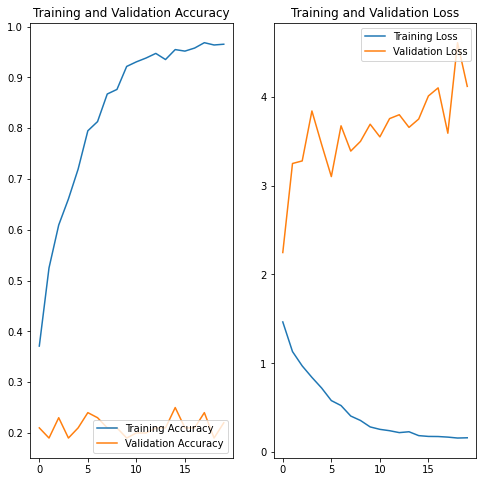

In [24]:
plot_model_performace(history9, num_epochs)

Model appears to be overfitting, as indicated by the growing gap between training and validation performance.

## Model 10: With transfer learning

MobileNet as Base Model:

We are using MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) to load the pre-trained MobileNet model without the top classification layers. This allows us to use MobileNet as a feature extractor.

The include_top=False argument is important to exclude the final classification layers so that we can add custom layers on top.

First we will try without training the mobilenet weights

In [8]:
# Importing the transfer learning model:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

2025-01-29 09:32:44.165522: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2025-01-29 09:32:44.165587: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22101 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:81:00.0, compute capability: 8.6


17235968/17225924 [==============================] - 2s 0us/step


In [9]:
batch_size = 32
height = width = 120
img_index = [1,2,4,6,7,8,10,12,14,16,18,20,21,22,24,26,27,29]
# Assuming RGB images (3 channels)
input_shape = (len(img_index), height, width, 3)

mobileNetModel= Sequential()
mobileNetModel.add(TimeDistributed(mobilenet_transfer,input_shape=(input_shape)))


for layer in mobileNetModel.layers:
    layer.trainable = False


mobileNetModel.add(TimeDistributed(BatchNormalization()))
mobileNetModel.add(TimeDistributed(MaxPooling2D((2, 2))))
mobileNetModel.add(TimeDistributed(Flatten()))

mobileNetModel.add(LSTM(128))
mobileNetModel.add(Dropout(0.25))

mobileNetModel.add(Dense(128,activation='relu'))
mobileNetModel.add(Dropout(0.25))

mobileNetModel.add(Dense(5, activation='softmax'))


optimiser = optimizers.Adam()
mobileNetModel.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (mobileNetModel.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 18, 3, 3, 1024)   3228864   
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 18, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 18, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 18, 1024)         0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 128)               5

In [10]:
print("Total Params in model:", mobileNetModel.count_params())

Total Params in model: 3840453


In [11]:
import cv2
import imageio as imio
from PIL import Image

def generatorMobileNet(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    img_idx = [1,2,4,6,7,8,10,12,14,16,18,20,21,22,24,26,27,29]
    
    
    while True:
        t = np.random.permutation(folder_list)
        
# calculate the number of batches
        num_batches = int(len(t)/batch_size)
        
# we iterate over the number of batches
        for batch in range(num_batches): 
            
# x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB          
            batch_data = np.zeros((batch_size,18,120,120,3))
# batch_labels is the one hot representation of the output
            batch_labels = np.zeros((batch_size,5))

# iterate over the batch_size    
            for folder in range(batch_size): 
# read all the images in the folder        
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
#  Iterate over the frames/images of a folder to read them in    
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
#crop the images and resize them. Note that the images are of 2 different shape 
#and the conv3D will throw error if the inputs in a batch have different shapes
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(120,120),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(120,120),interpolation = cv2.INTER_AREA).astype(np.float32)
                                
#normalise and feed in the image

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
#you yield the batch_data and the batch_labels, remember what does yield do                
            yield batch_data, batch_labels 

        
# write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,18,120,120,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(120,120),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(120,120),interpolation = cv2.INTER_AREA).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [12]:
train_generator = generatorMobileNet(train_path, train_doc, batch_size)
val_generator = generatorMobileNet(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4)

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [13]:
history10 = mobileNetModel.fit(
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=num_epochs, 
    verbose=1, 
    callbacks=callbacks_list, 
    validation_data=val_generator, 
    validation_steps=validation_steps, 
    class_weight=None, 
    workers=1, 
    initial_epoch=0
)

Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/20


2025-01-29 09:33:03.373380: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302
2025-01-29 09:33:05.078063: I tensorflow/stream_executor/cuda/cuda_blas.cc:1792] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


21/21 [==============================] - ETA: 0s - loss: 1.4732 - categorical_accuracy: 0.3710Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_2025-01-2909_32_18.826589/model-00001-1.47316-0.37104-1.28721-0.57000.h5
21/21 [==============================] - 33s 1s/step - loss: 1.4732 - categorical_accuracy: 0.3710 - val_loss: 1.2872 - val_categorical_accuracy: 0.5700 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 0.9065 - categorical_accuracy: 0.6742
Epoch 00002: saving model to model_init_2025-01-2909_32_18.826589/model-00002-0.90648-0.67421-0.90366-0.70000.h5
21/21 [==============================] - 18s 917ms/step - loss: 0.9065 - categorical_accuracy: 0.6742 - val_loss: 0.9037 - val_categorical_accuracy: 0.7000 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 0.4767 - categorical_accuracy: 0.8718
Epoch 00003: saving model to model_init_2025-01-2909_32_18.826589/m

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

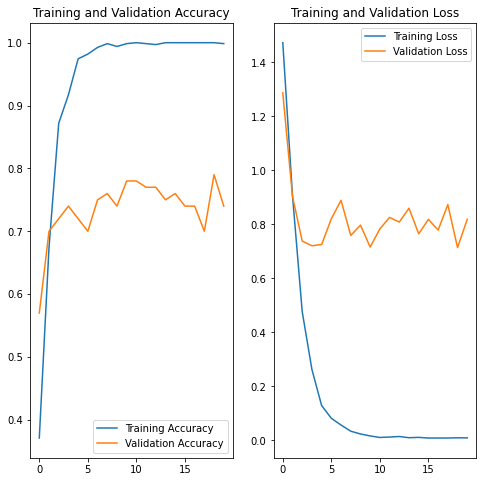

In [14]:
plot_model_performace(history10, num_epochs)

- Training Accuracy is excellent, nearing 100%.
- Validation Accuracy is plateauing and fluctuating, indicating overfitting.
- The model is performing well on the training data but is struggling to generalize effectively to the validation set, likely due to overfitting.

## Model 11: Transfer learning with training all the weights

In [15]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

input_shape = (18,120,120,3)
        
mobileNetModelWeight = Sequential()
mobileNetModelWeight.add(TimeDistributed(mobilenet_transfer,input_shape=(input_shape)))


mobileNetModelWeight.add(TimeDistributed(BatchNormalization()))
mobileNetModelWeight.add(TimeDistributed(MaxPooling2D((2, 2))))
mobileNetModelWeight.add(TimeDistributed(Flatten()))

mobileNetModelWeight.add(GRU(128))
mobileNetModelWeight.add(Dropout(0.25))

mobileNetModelWeight.add(Dense(128,activation='relu'))
mobileNetModelWeight.add(Dropout(0.25))

mobileNetModelWeight.add(Dense(5, activation='softmax'))


optimiser = optimizers.Adam()
mobileNetModelWeight.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (mobileNetModel.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 18, 3, 3, 1024)   3228864   
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 18, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 18, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 18, 1024)         0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 128)               5

In [16]:
train_generator = generatorMobileNet(train_path, train_doc, batch_size)
val_generator = generatorMobileNet(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4)

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [17]:
history11 = mobileNetModelWeight.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 32


/tmp/ipykernel_302/798082369.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history11 = mobileNetModelWeight.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.2437 - categorical_accuracy: 0.4932Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_2025-01-2909_32_18.826589/model-00001-1.24370-0.49321-1.37906-0.37000.h5
21/21 [==============================] - 21s 920ms/step - loss: 1.2437 - categorical_accuracy: 0.4932 - val_loss: 1.3791 - val_categorical_accuracy: 0.3700 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 0.4682 - categorical_accuracy: 0.8115
Epoch 00002: saving model to model_init_2025-01-2909_32_18.826589/model-00002-0.46822-0.81146-0.96637-0.62000.h5
21/21 [==============================] - 18s 894ms/step - loss: 0.4682 - categorical_accuracy: 0.8115 - val_loss: 0.9664 - val_categorical_accuracy: 0.6200 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 0.1707 - categorical_accuracy: 0.9427
Epoch 00003: saving model to model_init_2025-01-2909_

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

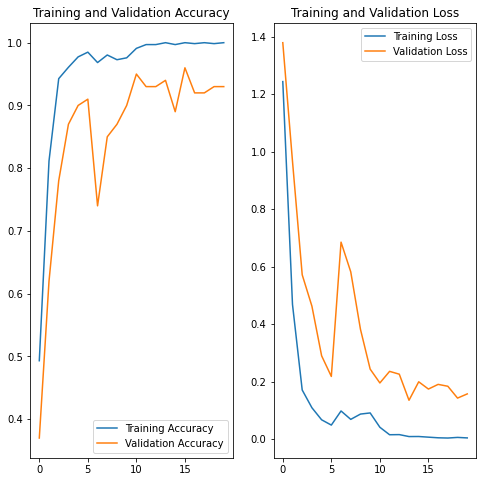

In [18]:
plot_model_performace(history11, num_epochs)

The model is performing very well. 

Loss & Accuracy Trends:
- Training Loss: The training loss decreases from 1.2437 at epoch 1 to 0.0040 at epoch 20. This shows rapid improvement in the model's ability to minimize error.
- Training Accuracy: Training accuracy starts at 49.32% at epoch 1 and rises to 100% by epoch 20, which is a good indicator of the model improving its performance.
- Validation Loss: The validation loss fluctuates, starting at 1.3791 and dropping to 0.1571 by epoch 20. This suggests good generalization but with some variability (more evident in the first half of training).
- Validation Accuracy: The validation accuracy starts at 37% and rises steadily, reaching 93% by epoch 20, indicating good performance on the validation set.

This model with Transfer learning LSTM with training mobilenet weights seems to offer the best performance. Hence this model is finalized.
